In [274]:

import os
from collections import Counter
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

mathlib_path = '../../.lake/packages/mathlib'
tactics_path = './exported/tactics.txt'
commands_path = './exported/commands.txt'

'''

I found this command that can print all tactic names and docstrings currently imported.

```
import Mathlib
#help tactic
```

Unfortunately, `#help` does not print the module name of the tactic,
so I modified its code a bit. The modified code is in `myhelp.lean`.
You can copy-paste the code into your folder with mathlib installed and run it.

I then copy-pasted the output in the infoview into files called `tactics.txt` and `commands.txt`
and processed it with the python script in `postprocess.ipynb`.

`sort.ipynb` reads all `.lean` files in `./lake/packages/mathlib`,
splits the text into "tokens" by parentheses, spaces, and line breaks, and counts the tokens.
(This crude method does not count accurately though.)
It then sorts the tactics by number of occurances as tokens, visualizes the counts,
and writes a `README.md` markdown file.

'''

'\n\nI found this command that can print all tactic names and docstrings currently imported.\n\n```\nimport Mathlib\n#help tactic\n```\n\nUnfortunately, `#help` does not print the module name of the tactic,\nso I modified its code a bit. The modified code is in `myhelp.lean`.\nYou can copy-paste the code into your folder with mathlib installed and run it.\n\nI then copy-pasted the output in the infoview into files called `tactics.txt` and `commands.txt`\nand processed it with the python script in `postprocess.ipynb`.\n\n`sort.ipynb` reads all `.lean` files in `./lake/packages/mathlib`,\nsplits the text into "tokens" by parentheses, spaces, and line breaks, and counts the tokens.\n(This crude method does not count accurately though.)\nIt then sorts the tactics by number of occurances as tokens, visualizes the counts,\nand writes a `README.md` markdown file.\n\n'

In [275]:
token_counter = Counter()

'''
walk through .lean files in ../../.lake/packages/mathlib,
simply split by spaces and line breaks, and count the "tokens" 
'''

for root, dirs, files in os.walk(mathlib_path):
    for file in files:
        if not file.endswith('.lean'):
            continue
        text = open(os.path.join(root, file), 'r').read()
        for symbol in '(){}[]⟨⟩,.':
            text = text.replace(symbol, ' ' + symbol + ' ')
        token_counter.update(text.split())
# counter 

Let us first examine all tokens in Mathlib
Tokens for commands and tactics will be examined next.
Note that I only count Mathlib, not the Lean standard library.

There are 266605 unique tokens here.
The top most common tokens are:
.       1161177    )        699304    (        699255    :        581976    ,        435306    
[        308018    ]        308005    :=       267830    a        178388    f        173902    
x        166313    _        164807    }        136592    {        136584    #align   131178    
by       117062    =        115063    α        113512    theorem  105989    s        100429    
i         90437    h         90202    n         87742    the       83487    fun       82141    
=>        81293    simp      78532    R         76167    ⟨         73369    ⟩         73368    
b         68342    of        67256    →         66794    1         63792    -/        62095    
rw        57509    p         56824    *         54203    g         54089    0         53824    
i

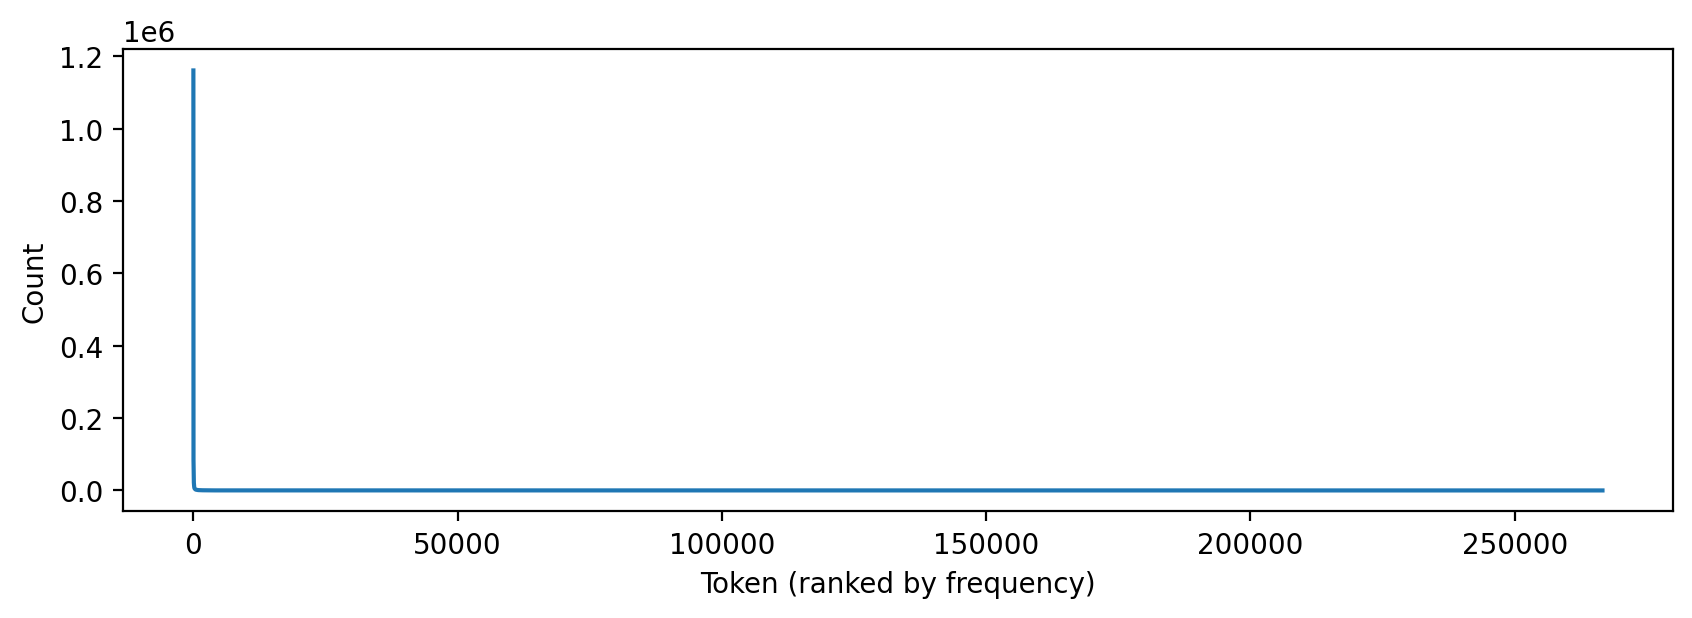

2. That is hard to read, let us plot it on a log scale.


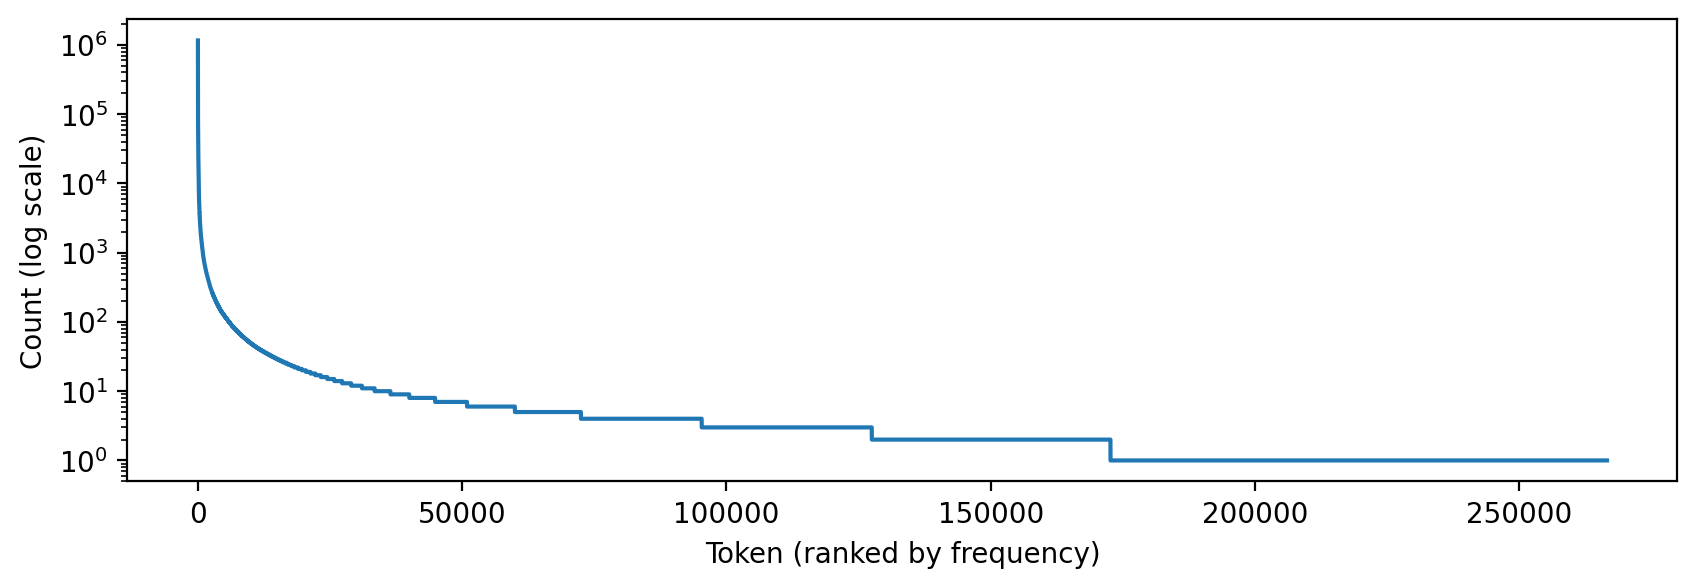

3. Let take y = 1 / frequency to verify Zipf's law. This should look like a straight line.


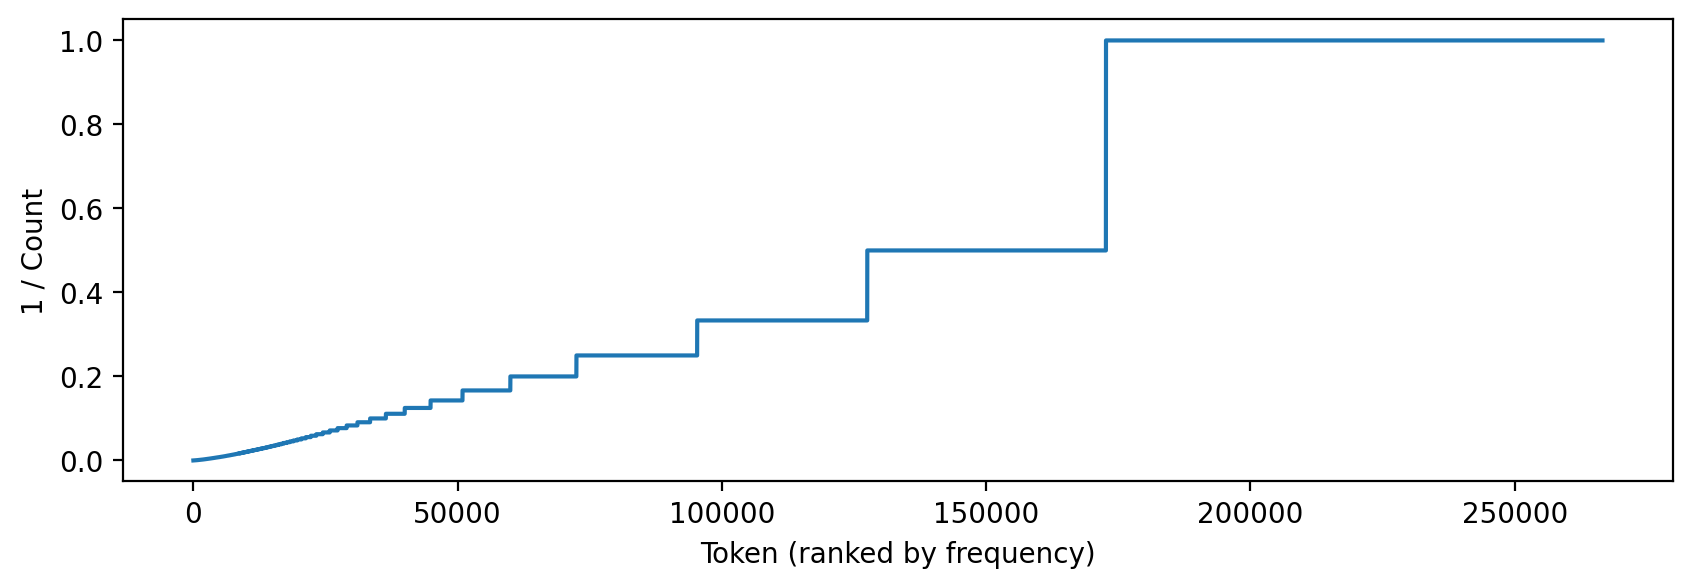

4. Let us take the top 1/16 frequent tokens to get rid of the long tail. 


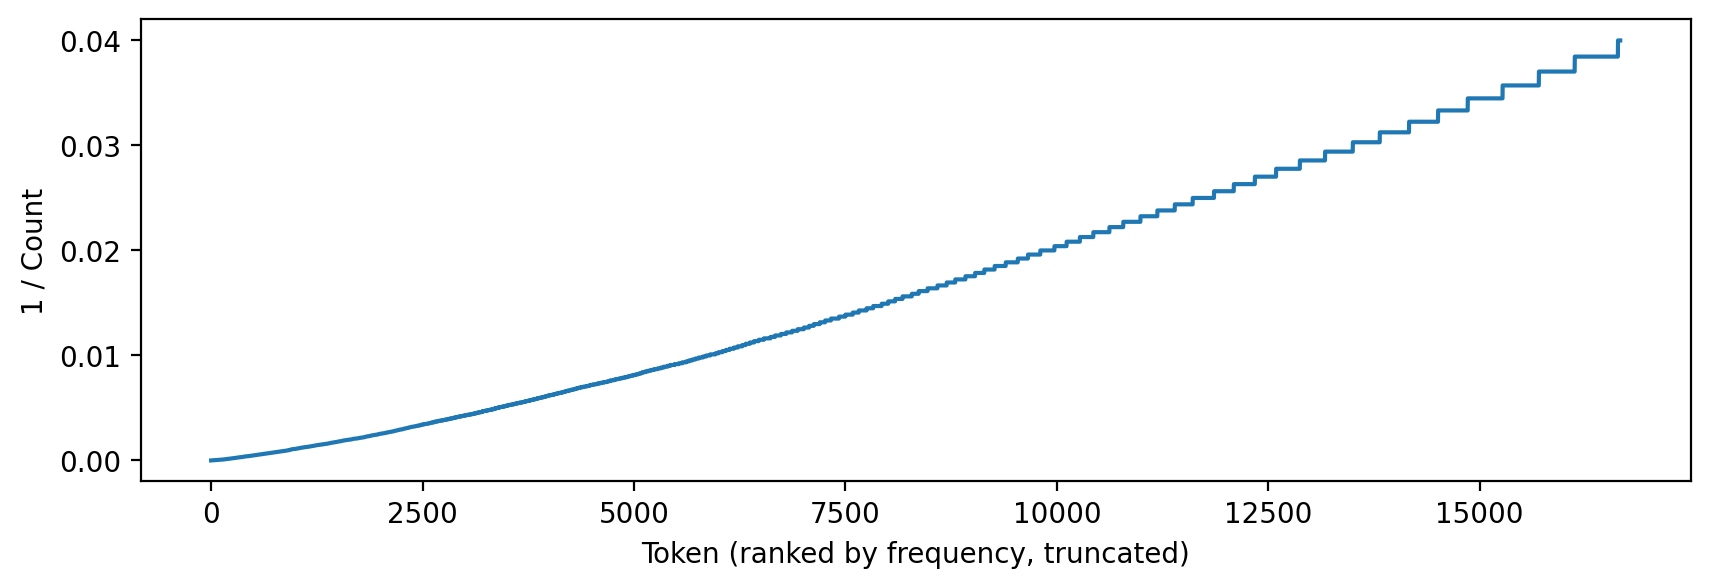

In [276]:

print('Let us first examine all tokens in Mathlib')
print('Tokens for commands and tactics will be examined next.')
print('Note that I only count Mathlib, not the Lean standard library.')
print()

def plot(counter, count_log_path, scatter=False):
    print(f'There are {len(counter)} unique tokens here.')

    print('The top most common tokens are:')
    for i, (token, freq) in enumerate(counter.most_common(50)):
        print(f"{token:7} {freq:7}", end='    ')
        if i % 5 == 4:
            print()

    print(f'see more in {count_log_path}')
    with open(count_log_path, 'w') as f:
        for token, freq in counter.most_common():
            f.write(f"{token} {freq}\n")

    if scatter:
        config = dict(
            linestyle='',
            marker='.',
            markersize=4,
            alpha=0.5,
        )
    else:
        config = dict()
    
    print('1. Let us sort them by frequency and plot the counts.')
    plt.figure(figsize=(10, 3))
    plt.plot(sorted(counter.values(), reverse=True), **config)
    plt.xlabel('Token (ranked by frequency)')
    plt.ylabel('Count')
    plt.show()

    print('2. That is hard to read, let us plot it on a log scale.')
    plt.figure(figsize=(10, 3))
    plt.plot(sorted(counter.values(), reverse=True), **config)
    plt.yscale('log')
    plt.xlabel('Token (ranked by frequency)')
    plt.ylabel('Count (log scale)')
    plt.show()

    print('3. Let take y = 1 / frequency to verify Zipf\'s law. This should look like a straight line.')
    plt.figure(figsize=(10, 3))
    plt.plot(
        [1/freq if freq > 0 else 1
         for freq in sorted(counter.values(), reverse=True)],
        **config
    )
    plt.xlabel('Token (ranked by frequency)')
    plt.ylabel('1 / Count')
    plt.show()


    print('4. Let us take the top 1/16 frequent tokens to get rid of the long tail. ')
    plt.figure(figsize=(10, 3))
    plt.plot(
        [1/freq if freq > 0 else 1
         for freq in sorted(counter.values(), reverse=True)[:len(counter)//16]],
        **config
    )
    plt.xlabel('Token (ranked by frequency, truncated)')
    plt.ylabel('1 / Count')
    plt.show()

plot(token_counter, './count/all_tokens.txt', scatter=False)

In [277]:

print('Processing commands and tactics into markdown docs.')

def read_decls(path):
    decls = []
    for decl in open(path, 'r').read().split('----help----\n')[:-1]:
        name, namespace, file, *doc = decl.split('\n')
        doc = '\n'.join(doc)
        decls.append((name, namespace, file, doc))
    subset_counter = Counter()
    for name, namespace, file, doc in decls:
        subset_counter[name] = token_counter[name]
    return decls, subset_counter

tactics, tactics_counter = read_decls(tactics_path)
commands, commands_counter = read_decls(commands_path)





def write_markdown(decls, counter, path):
    with open(path, 'w') as f:
        total = sum(counter.values())

        # different pieces of syntax with different docs etc.
        # can have the same first expected token (same name)
        decls_dict = {}
        for i, (name, namespace, file, doc) in enumerate(decls):
            if name not in decls_dict:
                decls_dict[name] = []
            decls_dict[name].append((namespace, file, doc))

        # the style of a division line
        f.write(
'''
<style>
.division {
    border-bottom: 2px solid #eee;
}
</style>
''')
        for i, (name, freq) in enumerate(counter.most_common()):
            f.write(f'### {i}. {name}\n')
            freq = counter[name]
            # we will add a link to Mathlib Docs
            # For example https://leanprover-community.github.io/mathlib4_docs/Mathlib/Algebra/AddConstMap/Basic.html#AddConstMap
            for namespace, file, doc in decls_dict[name]:
                link = f'https://leanprover-community.github.io/mathlib4_docs/{file.replace(".", "/")}.html#{namespace}'
                # f.write('| Frequency | File | Doc |\n')
                # f.write('|-----------|------|-----|\n')
                # f.write(f'|{freq}, {freq / total:.2%} | import {file} | [link]({link}) |\n')
                f.write(f'> Syntax full name: {namespace}.{name} <br>')
                f.write(f'Frequency: {freq}, {freq / total:.2%} <br>')
                f.write(f'File: import {file} <br>')
                f.write(f'[Mathlib4 Docs]({link})\n\n')
                f.write('\n')
                f.write(doc)
                f.write('\n')
            f.write('<div class="division"></div>\n\n')

write_markdown(tactics, tactics_counter, './markdown/tactics.md')
write_markdown(commands, commands_counter, './markdown/commands.md')

Processing commands and tactics into markdown docs.


Now let us examine all tokens in tactics.

There are 472 unique tokens here.
The top most common tokens are:
(        699255    _        164807    simp      78532    rw        57509    rfl       39937    
exact     37282    have      25066    symm      20096    refine    16484    apply     14659    
ext       13979    let       12823    set       12248    intro     11295    trans     11004    
open      10290    simpa      8485    obtain     7822    rintro     6632    <;>        6545    
rcases     6031    simp_rw    5533    lift       4992    dsimp      4722    set_option    4315    
ring       4260    show       4130    cases      4128    use        4075    left       3752    
rwa        3548    right      3447    congr      3274    else       3254    mono       3189    
convert    3178    by_cases    3114    group      3043    constructor    2962    calc       2489    
norm_cast    2472    suffices    2316    haveI      2214    cases'     2019    change     2016    
case       1956 

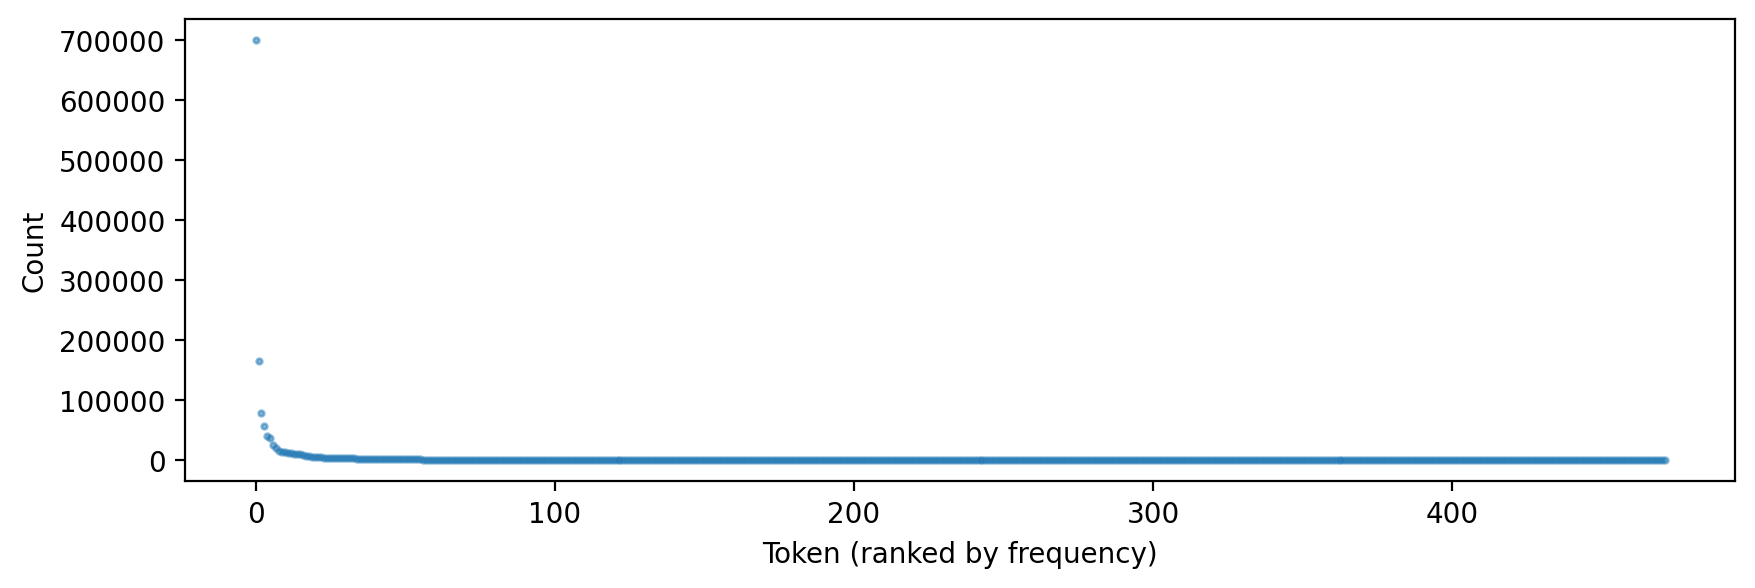

2. That is hard to read, let us plot it on a log scale.


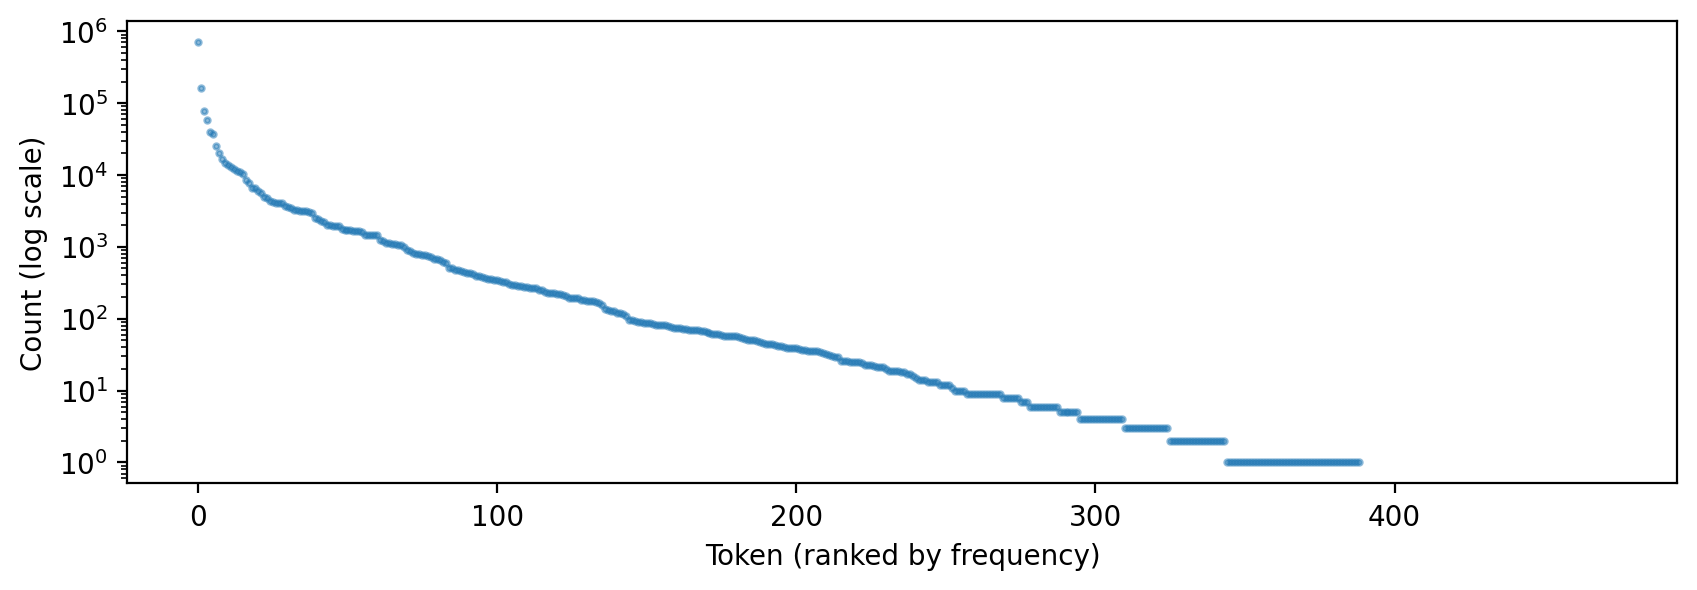

3. Let take y = 1 / frequency to verify Zipf's law. This should look like a straight line.


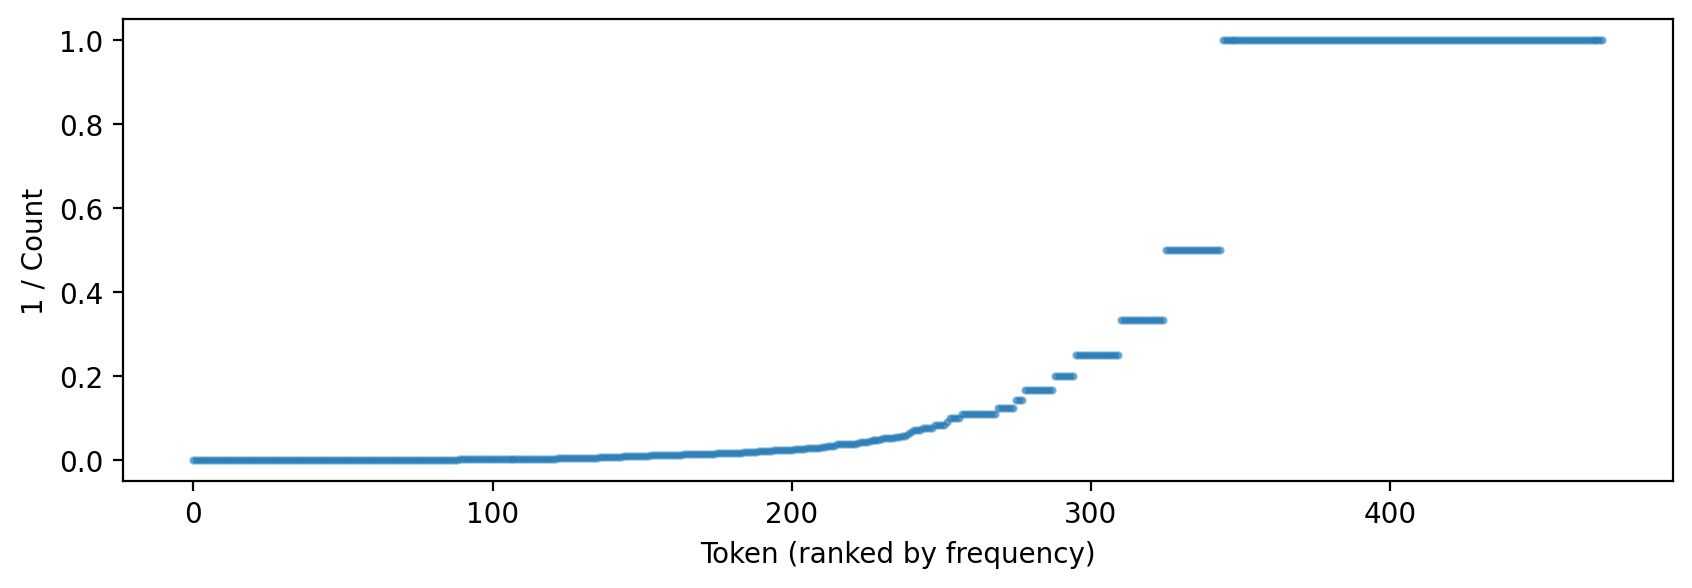

4. Let us take the top 1/16 frequent tokens to get rid of the long tail. 


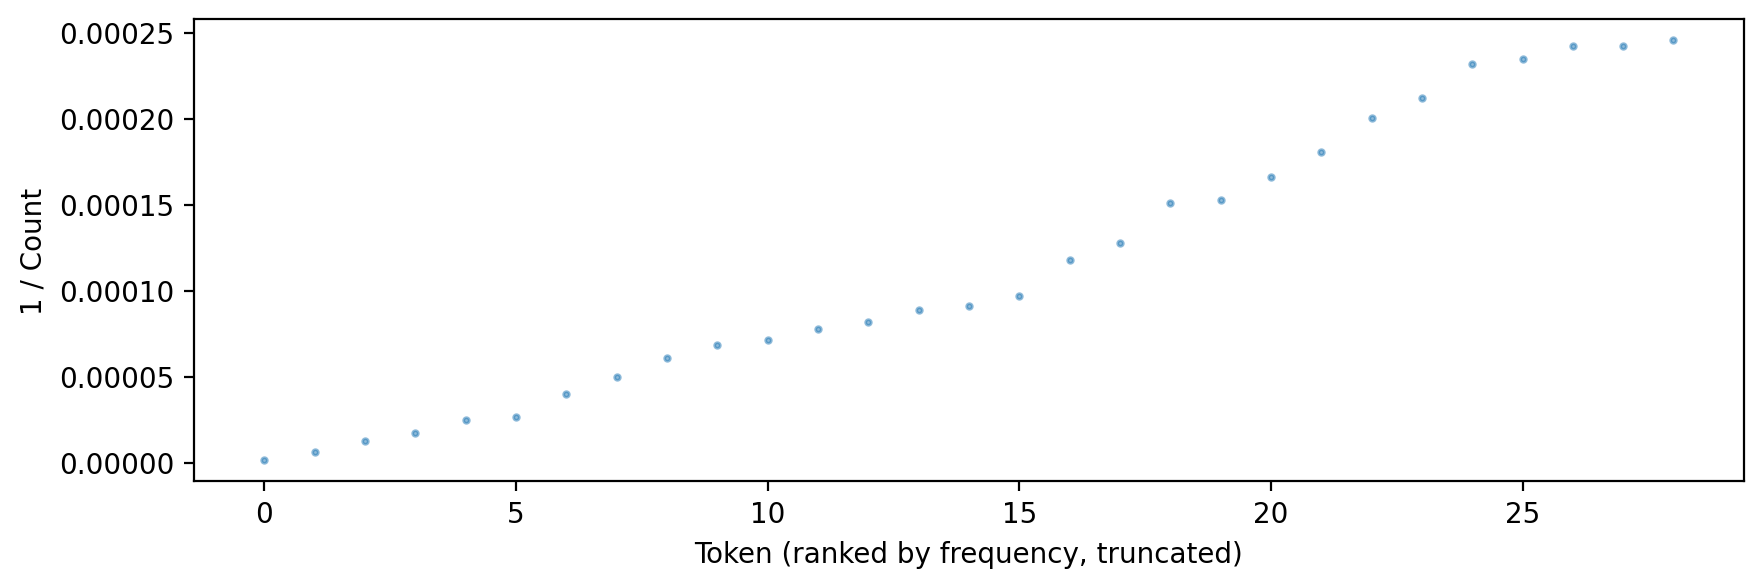

In [278]:

print('Now let us examine all tokens in tactics.')
print()

plot(tactic_counter, './count/tactics.txt', scatter=True)



Now let us examine all tokens in commands.

There are 148 unique tokens here.
The top most common tokens are:
#align   131178    in        35162    variable   25406    import    18386    end       18251    
section   11566    open      10290    namespace    8330    /-!        7914    noncomputable    4873    
set_option    4315    #align_import    3265    alias      2522    attribute    2339    class      2284    
universe    2045    scoped     1988    notation    1572    #noalign     830    variables     618    
syntax      473    #guard_msgs     472    assert_not_exists     322    deriving     314    initialize_simps_projections     191    
export      188    macro       160    parameter     156    irreducible_def     134    add_decl_doc     132    
elab        129    #check      129    notation3     123    #adaptation_note     122    include     104    
run_cmd      80    #eval        78    macro_rules      73    elab_rules      71    variable?      54    
suppress_compilation      

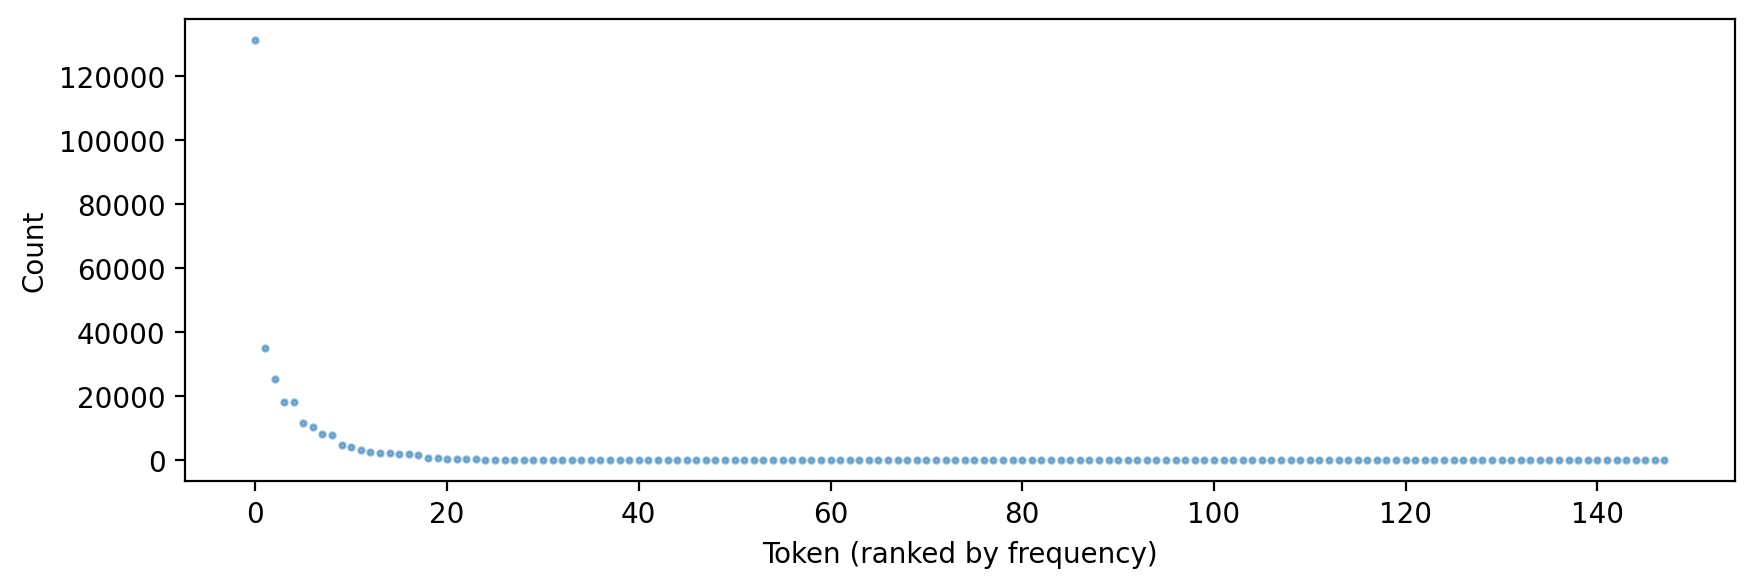

2. That is hard to read, let us plot it on a log scale.


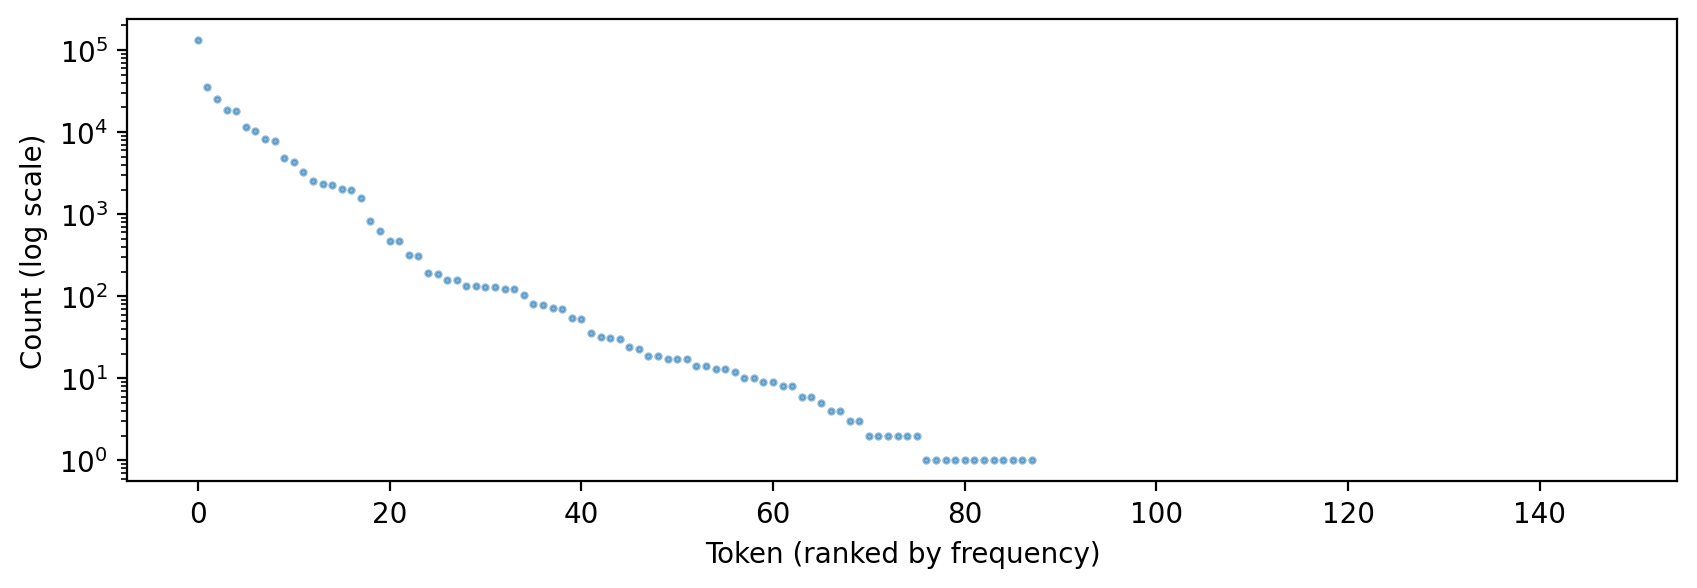

3. Let take y = 1 / frequency to verify Zipf's law. This should look like a straight line.


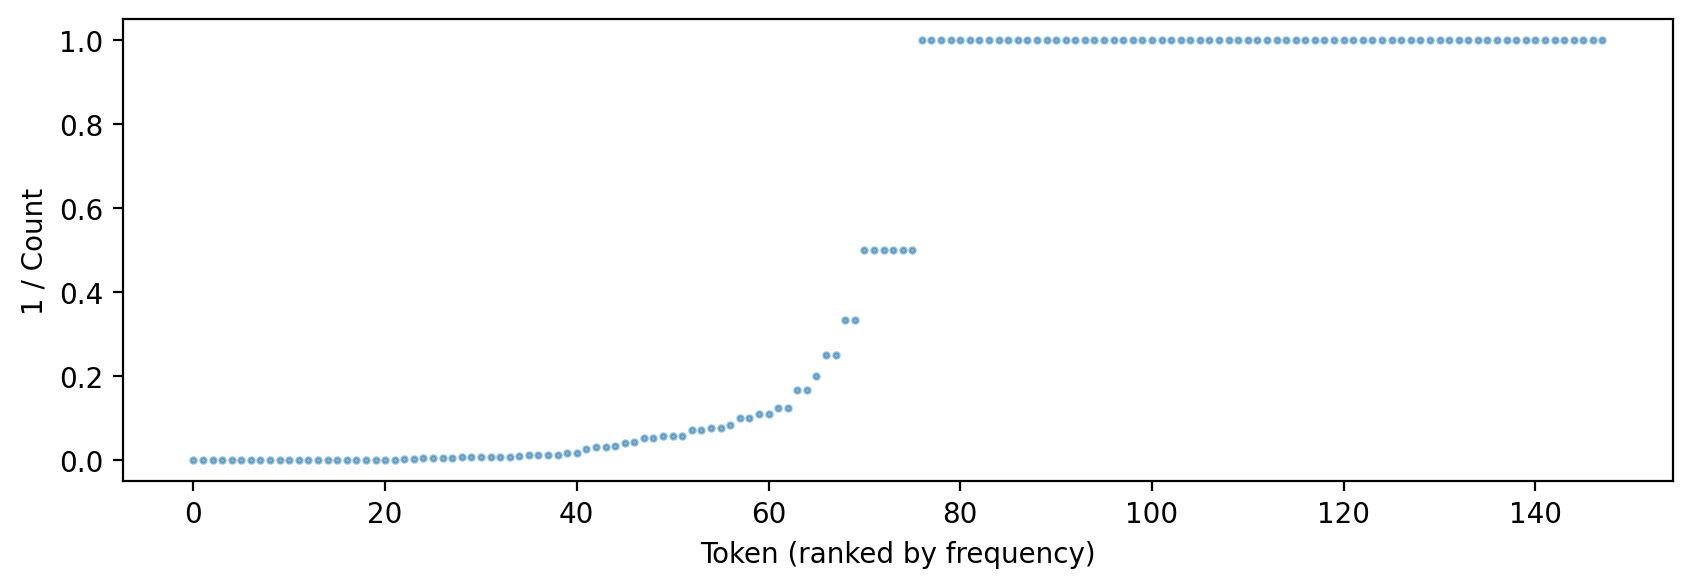

4. Let us take the top 1/16 frequent tokens to get rid of the long tail. 


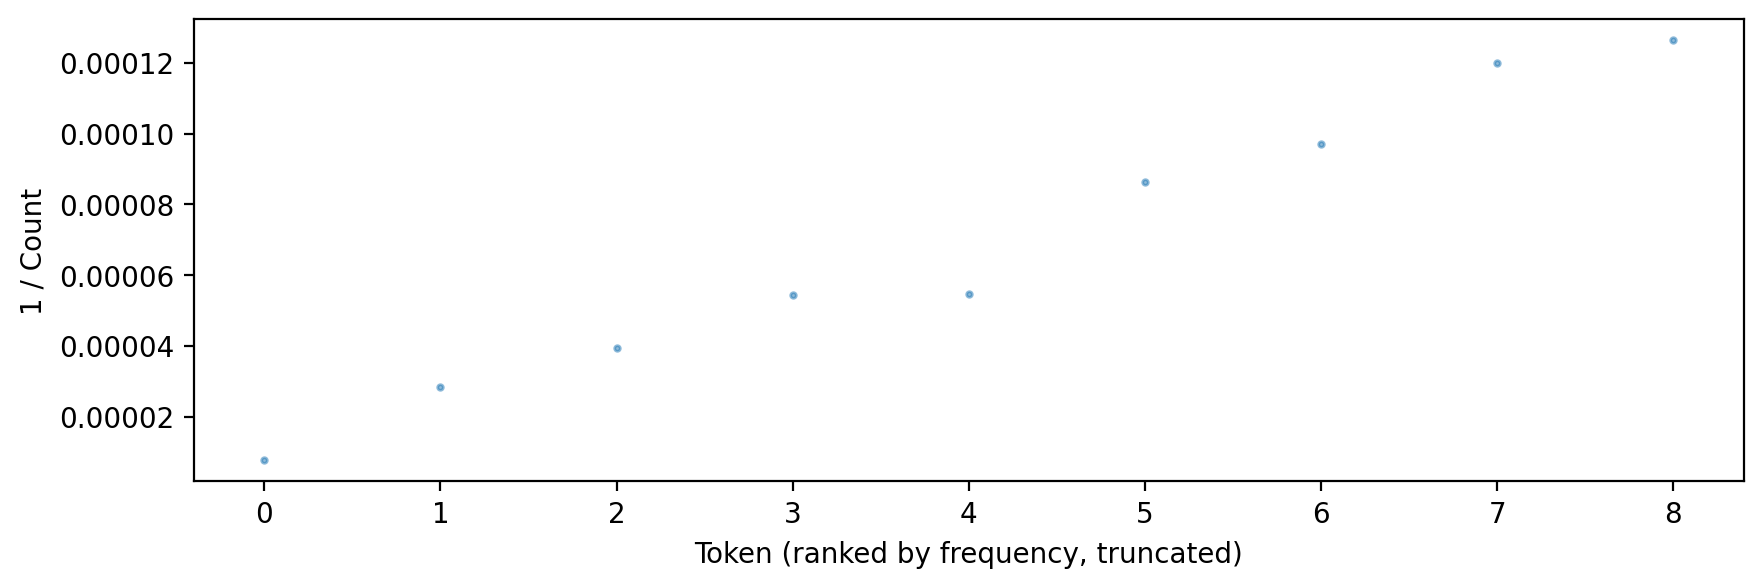

In [279]:
print('Now let us examine all tokens in commands.')
print()

plot(command_counter, './count/commands.txt', scatter=True)

Finally, here is a horizontal bar plot for all ~500 tactics.
Here x-axis is log-scaled.


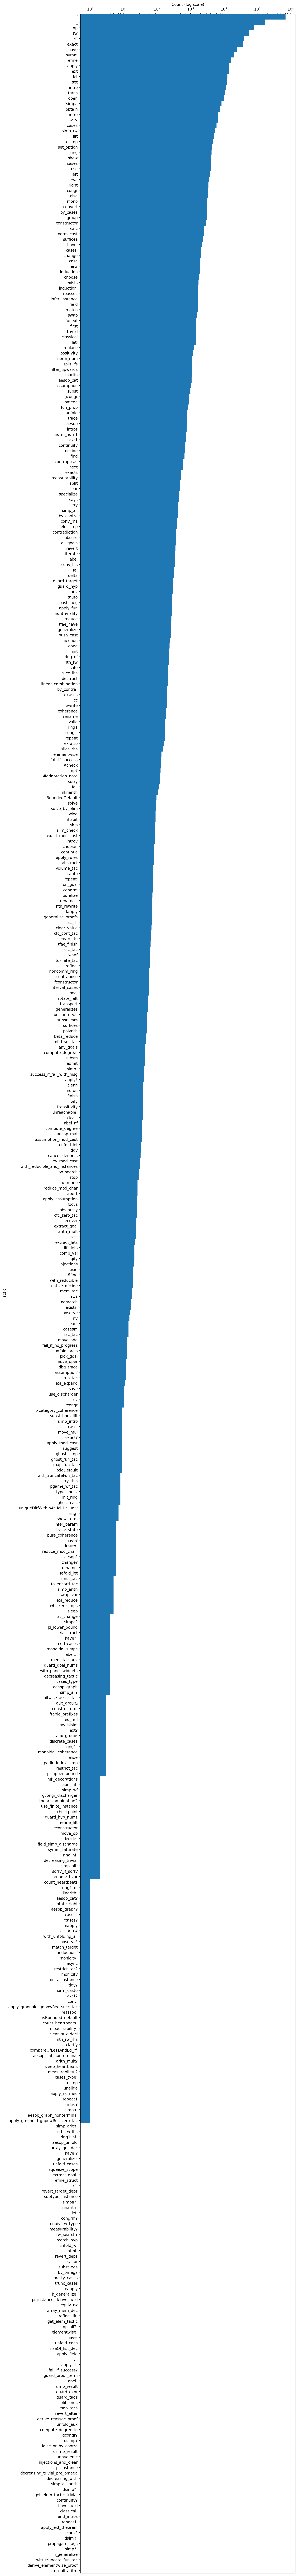

In [280]:
print('Finally, here is a horizontal bar plot for all ~500 tactics.')
print('Here x-axis is log-scaled.')

tactic_counter_lst = tactic_counter.most_common()

plt.figure(figsize=(10, 120))
plt.barh(
    [name for name, _ in tactic_counter_lst][::-1],
    [freq for _, freq in tactic_counter_lst][::-1],
    height=1,
)
plt.margins(y=0)
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()
plt.xscale('log')
plt.xlabel('Count (log scale)')
plt.ylabel('Tactic')

plt.show()

